In [1]:
# from getopt import getopt
# import cloudpickle
# import pickle
# import sys
# import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import logit, expit
from scipy.stats import uniform, norm, bernoulli, betabinom
from scipy.stats import linregress
from scipy.stats import spearmanr
# from statsmodels.stats.proportion import proportions_ztest
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az
from modeltools import mcmc_diagnostics, create_summary_stat
from downcast import downcast_df
import jax
from pymc.sampling_jax import sample_numpyro_nuts
# from time import time, sleep
# from datetime import timedelta

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/roger/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/roger/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
2023-02-11 11:40:25.143414: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-11 11:40:25.174109: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared 

## Checking pval

In [7]:
oa0_test_results = (pd.read_csv("data/simulations/oa0_test.csv")
                    .sort_values("sim_id")
                    .reset_index()
                    .drop(columns="index"))
oa1_test_results = (pd.read_csv("data/simulations/oa1_test.csv")
                    .sort_values("sim_id")
                    .reset_index()
                    .drop(columns="index"))

In [8]:
print("Checking if all values for the following columns match\n")
for c in ["p_diff", "n_raters", "scores_per_r", "total_scores", "seed"]:
    print(c, all(oa0_test_results[c]==oa1_test_results[c]))

Checking if all values for the following columns match

p_diff True
n_raters True
scores_per_r True
total_scores True
seed True


In [9]:
a=oa0_test_results
b=oa1_test_results.rename(columns={"propz_pval":"propz_pvalOA", "bht_pval":"bht_pvalOA"})
c=pd.merge(a,b[["sim_id", "propz_pvalOA", "bht_pvalOA"]],on="sim_id")
c = c[["sim_id", "trial_id", "p_diff", "n_raters", "scores_per_r", "total_scores", 
       "seed", "propz_pval", "propz_pvalOA", "bht_pval", "bht_pvalOA"]]
c["propz_OA_factor"]=np.log10(c["propz_pvalOA"]/c["propz_pval"])
c["propz_OA_factor"] = c["propz_OA_factor"].round(4)
c["bht_pval"] += 1e-3
c["bht_pvalOA"] += 1e-3
c["bht_OA_factor"]=np.log10(c["bht_pvalOA"]/c["bht_pval"])



In [10]:
c["bht_OA_factor"].sum()

2.4203618171882697

In [11]:
var = "bht_OA_factor"
c.sort_values(var)[:20]

,sim_id,trial_id,p_diff,n_raters,scores_per_r,total_scores,seed,propz_pval,propz_pvalOA,bht_pval,bht_pvalOA,propz_OA_factor,bht_OA_factor
7,7,0,0.055,50,35,1750,49,9.502364e-02,8.298478e-02,0.043,0.016,-0.0588,-0.429348
9,9,0,0.055,76,35,2660,51,1.769225e-02,2.739408e-02,0.008,0.003,0.1899,-0.425969
0,0,0,0.055,139,35,4865,42,2.460470e-11,1.830516e-10,0.001,0.001,0.8716,0.000000
1,1,0,0.055,82,35,2870,43,4.337023e-04,7.216480e-05,0.001,0.001,-0.7789,0.000000
3,3,0,0.055,120,35,4200,45,2.698574e-08,9.428962e-11,0.001,0.001,-2.4567,0.000000
4,4,0,0.055,128,35,4480,46,2.094640e-05,7.027142e-07,0.001,0.001,-1.4743,0.000000
8,8,0,0.055,146,35,5110,50,1.604384e-08,2.854252e-08,0.001,0.001,0.2502,0.000000
10,10,0,0.055,109,35,3815,52,2.901432e-06,1.121891e-03,0.001,0.001,2.5873,0.000000
11,11,0,0.055,98,35,3430,53,6.310440e-11,1.544340e-06,0.001,0.001,4.3887,0.000000
5,5,0,0.055,63,35,2205,47,1.109440e-03,1.659407e-02,0.001,0.004,1.1748,0.602060


In [12]:
c.sort_values(var)[-20:]

,sim_id,trial_id,p_diff,n_raters,scores_per_r,total_scores,seed,propz_pval,propz_pvalOA,bht_pval,bht_pvalOA,propz_OA_factor,bht_OA_factor
7,7,0,0.055,50,35,1750,49,9.502364e-02,8.298478e-02,0.043,0.016,-0.0588,-0.429348
9,9,0,0.055,76,35,2660,51,1.769225e-02,2.739408e-02,0.008,0.003,0.1899,-0.425969
0,0,0,0.055,139,35,4865,42,2.460470e-11,1.830516e-10,0.001,0.001,0.8716,0.000000
1,1,0,0.055,82,35,2870,43,4.337023e-04,7.216480e-05,0.001,0.001,-0.7789,0.000000
3,3,0,0.055,120,35,4200,45,2.698574e-08,9.428962e-11,0.001,0.001,-2.4567,0.000000
4,4,0,0.055,128,35,4480,46,2.094640e-05,7.027142e-07,0.001,0.001,-1.4743,0.000000
8,8,0,0.055,146,35,5110,50,1.604384e-08,2.854252e-08,0.001,0.001,0.2502,0.000000
10,10,0,0.055,109,35,3815,52,2.901432e-06,1.121891e-03,0.001,0.001,2.5873,0.000000
11,11,0,0.055,98,35,3430,53,6.310440e-11,1.544340e-06,0.001,0.001,4.3887,0.000000
5,5,0,0.055,63,35,2205,47,1.109440e-03,1.659407e-02,0.001,0.004,1.1748,0.602060


## Checking scores

In [2]:
def postrr_var(n_success, total):
    a = n_success+1
    b = total-n_success+1
    return a*b/((a+b+1)*(a+b)**2)

def postrr_p(n_success, total):
    a = n_success+1
    b = total-n_success+1
    return betabinom.pmf(
        n=1,
        k=1,
        a=a,
        b=b
    )

In [14]:
sim_id = 5
test = pd.read_csv(f"data/oa0_test/score_{sim_id}.csv")
testOA = pd.read_csv(f"data/oa1_test/score_{sim_id}.csv")

In [15]:
# Checking expected variance reduction
scores=test
s = (scores.groupby("sim_topic_id").agg({"intrusion":"sum"})
     .rename(columns={"intrusion":"sum"}).reset_index())
c = (scores.groupby("sim_topic_id").agg({"intrusion":"count"})
     .rename(columns={"intrusion":"count"}).reset_index())
topic_sd = pd.merge(s, c, on="sim_topic_id")

# Calculating variance
topic_sd["sd"] = postrr_var(topic_sd["sum"], topic_sd["count"])**0.5

# Calculation priority values (wright_equivalence_2012)
topic_sd["priority_value"] = topic_sd["sd"]/(topic_sd["count"] * (topic_sd["count"]+1))**0.5
topic_sd.sort_values("priority_value", ascending=False)

,sim_topic_id,sum,count,sd,priority_value
20,20,17,21,0.084195,0.003917
59,59,16,23,0.091483,0.003894
80,80,6,23,0.088056,0.003748
38,38,8,24,0.091557,0.003738
49,49,13,25,0.094426,0.003704
...,...,...,...,...,...
76,76,29,29,0.031234,0.001059
74,74,37,39,0.040183,0.001017
90,90,30,30,0.030288,0.000993
98,98,33,33,0.027766,0.000829


In [262]:
# Checking expected variance reduction
scores=testOA
s = (scores.groupby("sim_topic_id").agg({"intrusion":"sum"})
     .rename(columns={"intrusion":"sum"}).reset_index())
c = (scores.groupby("sim_topic_id").agg({"intrusion":"count"})
     .rename(columns={"intrusion":"count"}).reset_index())
topic_sd = pd.merge(s, c, on="sim_topic_id")

# Calculating variance
topic_sd["sd"] = postrr_var(topic_sd["sum"], topic_sd["count"])**0.5

# Calculation priority values (wright_equivalence_2012)
topic_sd["priority_value"] = topic_sd["sd"]/(topic_sd["count"] * (topic_sd["count"]+1))**0.5
topic_sd.sort_values("priority_value", ascending=False)

,sim_topic_id,sum,count,sd,priority_value
69,69,20,21,0.057516,0.002676
87,87,21,21,0.041627,0.001937
49,49,21,21,0.041627,0.001937
1,1,21,21,0.041627,0.001937
16,16,21,21,0.041627,0.001937
...,...,...,...,...,...
55,55,23,53,0.066272,0.001239
34,34,23,53,0.066272,0.001239
33,33,23,53,0.066272,0.001239
21,21,30,53,0.066272,0.001239


## Inference

In [248]:
sim_id = 5
test = pd.read_csv(f"data/oa0_test/score_{sim_id}.csv")
testOA = pd.read_csv(f"data/oa1_test/score_{sim_id}.csv")

In [249]:
# Checking expected variance reduction
s = (testOA.groupby("sim_topic_id").agg({"intrusion":"sum"})
     .rename(columns={"intrusion":"sum"}).reset_index())
c = (testOA.groupby("sim_topic_id").agg({"intrusion":"count"})
     .rename(columns={"intrusion":"count"}).reset_index())
topic_sd = pd.merge(s, c, on="sim_topic_id")

In [250]:
# Creating synthetic Dataset
raters_per_topic = round(topic_sd["count"].mean())

total_scores = topic_sd["count"].sum()
topic_sd["probs"] = topic_sd["sum"]/topic_sd["count"]
topic_sd["ua_sum"] = round(topic_sd["probs"]*raters_per_topic,0)
topic_sd["ua_sum"] = topic_sd["ua_sum"].astype(int)
topic_sd["ua_count"] = raters_per_topic

In [251]:
# Creating synthetic dataset to match number of 0s and 1s
test = pd.DataFrame(columns=["trial_id", "sim_cordel_id", "sim_topic_id",
                             "sim_rater_id", "intrusion"])

for sim_topic_id in range(100):
    ua_sum = topic_sd[topic_sd["sim_topic_id"]==sim_topic_id]["ua_sum"].item()
    ua_count = topic_sd[topic_sd["sim_topic_id"]==sim_topic_id]["ua_count"].item()
    
    sim_cordel_id = sim_topic_id//50
    sim_rater_ids = np.random.choice(range(100), size=ua_count, replace=False)
    sim_rater_1s = np.random.choice(sim_rater_ids, size=ua_sum, replace=False)
    
    temp = pd.DataFrame(
        np.array([[0]*ua_count, [sim_cordel_id]*ua_count, [sim_topic_id]*ua_count,
         sim_rater_ids, [0]*ua_count]).T
        ,columns=["trial_id", "sim_cordel_id", "sim_topic_id", 
                  "sim_rater_id", "intrusion"])
    temp["intrusion"] = np.where(temp["sim_rater_id"].isin(sim_rater_1s), 1, 0)
    test = pd.concat([test, temp], ignore_index=True)
for c in test:
    test[c] = test[c].astype(int)

In [252]:
# Subtracting 50 from cordel 1 topic_ids to fix phantom topic_id problem
if test["sim_topic_id"].max()>50:
    test.loc[test["sim_cordel_id"]==1, "sim_topic_id"]-=50
if testOA["sim_topic_id"].max()>50:    
    testOA.loc[testOA["sim_cordel_id"]==1, "sim_topic_id"]-=50

In [253]:
# Common settings
n_chains = 2
seed = 41+sim_id
# seed = 21

SAMPLE_JAX = True
chain_method = "vectorized"

In [254]:
sample = test
glm_test = {"model":pm.Model()}
glm = glm_test

In [255]:
# sample = scores[scores["trial_id"]==0]
if seed != None:
    np.random.seed(seed)

# Bayesian hypothesis tests whether the two distributions in the sample are statisticaly significant
# Setting up numpy arrays for pymc
# Only 2 models and 1 corpus in simulation
corpus_array = np.array([0]*len(sample))
n_corpora = 1

model_array = np.array(sample["sim_cordel_id"])
n_models = sample["sim_cordel_id"].nunique()

cordel_array = np.array(sample["sim_cordel_id"])
n_cordels = sample["sim_cordel_id"].nunique()

topic_array = np.array([sample["sim_cordel_id"], sample["sim_topic_id"]])
n_topics = sample["sim_topic_id"].nunique()

rater_array = np.array(sample["sim_rater_id"])
n_raters = sample["sim_rater_id"].nunique()

score_array = np.array(sample["intrusion"])

# Model and MCMC specifications
empirical_mean = logit(0.75)
r_lambda = 2
t_lambda = 1
t_sigma = 1
# cm_lambda = 2
# cm_sigma = 1
mu_sigma = 1

# Rater, Topic, Cordel model

glm["model"] = pm.Model()
with glm["model"]:
    # Hyperparameter priors
#     raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
    topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
    cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")

#     sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
#     zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=empirical_mean, sigma=t_sigma, shape=(n_cordels, n_topics)) 
    mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma, shape=n_cordels)

    s = pm.Bernoulli(
            "s", 
            p=pm.math.invlogit(
                mu[cordels]+
                za[topics[0],topics[1]]*sigma_a),#+
#                 zr[raters]*sigma_r),
            observed=score_array, 
            dims="obs_id")
    
    c_mean = pm.Deterministic("c_mean", 
                              pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
                              dims="obs_id")
    c_diff = pm.Deterministic("c_diff", c_mean[1]- c_mean[0])
#     c_mean = pm.Deterministic("c_mean", 
#                               pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
#                               dims="obs_id")
#     c_diff = pm.Deterministic("c_diff", c_mean.reshape([n_cordels,1]) - c_mean.reshape([1,n_cordels]), dims="obs_id")

    if SAMPLE_JAX:
        glm["trace"]=sample_numpyro_nuts(chains=n_chains, draws=2_000, 
                                         random_seed=np.random.randint(2**20), chain_method=chain_method)
    else:
        glm["trace"]=pm.sample(chains=n_chains, random_seed=np.random.randint(2**20))

# n_negatives = (glm["trace"].posterior["c_diff"].sel({"obs_id":1, "c_diff_dim_1":0}) < 0).sum().item()

#     return  n_negatives/len(sample)

Compiling...
Compilation time =  0:00:00.801992
Sampling...


sample: 100%|███████████████████████████████| 3000/3000 [00:51<00:00, 58.71it/s]


Sampling time =  0:00:52.151003
Transforming variables...
Transformation time =  0:00:00.073256
Computing Log Likelihood...
Log Likelihood time =  0:00:02.314189


In [256]:
# Repeate code below again for OA settings
sample = testOA
glm_testOA = {"model":pm.Model()}
glm = glm_testOA

In [257]:
# sample = scores[scores["trial_id"]==0]
if seed != None:
    np.random.seed(seed)

# Bayesian hypothesis tests whether the two distributions in the sample are statisticaly significant
# Setting up numpy arrays for pymc
# Only 2 models and 1 corpus in simulation
corpus_array = np.array([0]*len(sample))
n_corpora = 1

model_array = np.array(sample["sim_cordel_id"])
n_models = sample["sim_cordel_id"].nunique()

cordel_array = np.array(sample["sim_cordel_id"])
n_cordels = sample["sim_cordel_id"].nunique()

topic_array = np.array([sample["sim_cordel_id"], sample["sim_topic_id"]])
n_topics = sample["sim_topic_id"].nunique()

rater_array = np.array(sample["sim_rater_id"])
n_raters = sample["sim_rater_id"].nunique()

score_array = np.array(sample["intrusion"])

# Model and MCMC specifications
empirical_mean = logit(0.75)
r_lambda = 2
t_lambda = 1
t_sigma = 1
# cm_lambda = 2
# cm_sigma = 1
mu_sigma = 1

# Rater, Topic, Cordel model

glm["model"] = pm.Model()
with glm["model"]:
    # Hyperparameter priors
#     raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
    topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
    cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")

#     sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
#     zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=empirical_mean, sigma=t_sigma, shape=(n_cordels, n_topics)) 
    mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma, shape=n_cordels)

    s = pm.Bernoulli(
            "s", 
            p=pm.math.invlogit(
                mu[cordels]+
                za[topics[0],topics[1]]*sigma_a),#+
#                 zr[raters]*sigma_r),
            observed=score_array, 
            dims="obs_id")
    
    c_mean = pm.Deterministic("c_mean", 
                              pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
                              dims="obs_id")
    c_diff = pm.Deterministic("c_diff", c_mean[1]- c_mean[0])
#     c_mean = pm.Deterministic("c_mean", 
#                               pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
#                               dims="obs_id")
#     c_diff = pm.Deterministic("c_diff", c_mean.reshape([n_cordels,1]) - c_mean.reshape([1,n_cordels]), dims="obs_id")

    if SAMPLE_JAX:
        glm["trace"]=sample_numpyro_nuts(chains=n_chains, draws=2_000, 
                                         random_seed=np.random.randint(2**20), chain_method=chain_method)
    else:
        glm["trace"]=pm.sample(chains=n_chains, random_seed=np.random.randint(2**20))

# n_negatives = (glm["trace"].posterior["c_diff"].sel({"obs_id":1, "c_diff_dim_1":0}) < 0).sum().item()

#     return  n_negatives/len(sample)

Compiling...
Compilation time =  0:00:00.803547
Sampling...


sample: 100%|███████████████████████████████| 3000/3000 [00:45<00:00, 65.36it/s]


Sampling time =  0:00:46.940925
Transforming variables...
Transformation time =  0:00:00.076822
Computing Log Likelihood...
Log Likelihood time =  0:00:02.084606


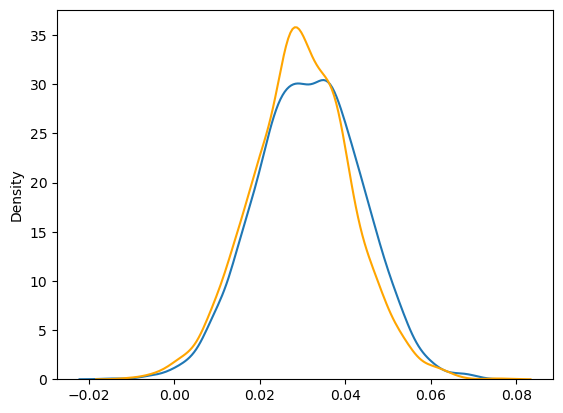

In [258]:
sns.kdeplot(glm_test["trace"].posterior["c_diff"].sel({"chain":0}), label="Uniform sampling")
sns.kdeplot(glm_testOA["trace"].posterior["c_diff"].sel({"chain":0}), color="orange", label="OA sampling")
# plt.legend()
plt.show()

In [184]:
glm_test["summary_stat"] = create_summary_stat(glm_test["trace"])
glm_testOA["summary_stat"] = create_summary_stat(glm_testOA["trace"])

# Deleting diagnostic columns
diag_cols = ['mcse_mean', 'mcse_sd', 'ess_bulk', 'ess_tail', 'r_hat']
glm_test["summary_stat"] = glm_test["summary_stat"].drop(columns=diag_cols)
glm_testOA["summary_stat"] = glm_testOA["summary_stat"].drop(columns=diag_cols)

# Creating Summary Stats
a = glm_test["summary_stat"]
b = glm_testOA["summary_stat"].rename(columns={c:c+"OA" for c in glm_testOA["summary_stat"].columns})
c = (pd.merge(a,b, left_on=["param", "param_num"], right_on=["paramOA", "param_numOA"])
       .drop(columns=["paramOA", "param_numOA"]))

In [186]:
# Plotting total variance of uniform vs OA topic effects
mu0 = c[(c["param"]=="mu")&(c["param_num"]=="0")]["mean"].item()
mu1 = c[(c["param"]=="mu")&(c["param_num"]=="1")]["mean"].item()
mu0OA = c[(c["param"]=="mu")&(c["param_num"]=="0")]["meanOA"].item()
mu1OA = c[(c["param"]=="mu")&(c["param_num"]=="1")]["meanOA"].item()

sigma_a = c[c["param"]=="sigma_a"]["mean"].item()
sigma_aOA = c[c["param"]=="sigma_a"]["meanOA"].item()

In [187]:
za = c[c["param"]=="za"]
za[["sim_cordel_id", "sim_topic_id"]] = za["param_num"].str.split(",", expand=True)
za["sim_cordel_id"] = za["sim_cordel_id"].str.strip().astype(int)
za["sim_topic_id"] = za["sim_topic_id"].str.strip().astype(int)

# za.loc[za["sim_cordel_id"]==0,"topic_eff_spread"] = expit(mu0 + za["hdi_97%"]*sigma_a)-expit(mu0 + za["hdi_3%"]*sigma_a)
# za.loc[za["sim_cordel_id"]==1,"topic_eff_spread"] = expit(mu1 + za["hdi_97%"]*sigma_a)-expit(mu1 + za["hdi_3%"]*sigma_a)
# za.loc[za["sim_cordel_id"]==0,"topic_eff_spreadOA"] = expit(mu0OA + za["hdi_97%OA"]*sigma_a)-expit(mu0OA + za["hdi_3%OA"]*sigma_a)
# za.loc[za["sim_cordel_id"]==1,"topic_eff_spreadOA"] = expit(mu1OA + za["hdi_97%OA"]*sigma_a)-expit(mu1OA + za["hdi_3%OA"]*sigma_a)

/tmp/ipykernel_4894/731552034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  za[["sim_cordel_id", "sim_topic_id"]] = za["param_num"].str.split(",", expand=True)
/tmp/ipykernel_4894/731552034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  za[["sim_cordel_id", "sim_topic_id"]] = za["param_num"].str.split(",", expand=True)
/tmp/ipykernel_4894/731552034.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [188]:
za["topic_eff_spread"] = expit(za["hdi_97%"]*sigma_a)-expit(za["hdi_3%"]*sigma_a)
za["topic_eff_spreadOA"] = expit(za["hdi_97%OA"]*sigma_a)-expit(za["hdi_3%OA"]*sigma_a)

/tmp/ipykernel_4894/4165366446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  za["topic_eff_spread"] = expit(za["hdi_97%"]*sigma_a)-expit(za["hdi_3%"]*sigma_a)
/tmp/ipykernel_4894/4165366446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  za["topic_eff_spreadOA"] = expit(za["hdi_97%OA"]*sigma_a)-expit(za["hdi_3%OA"]*sigma_a)


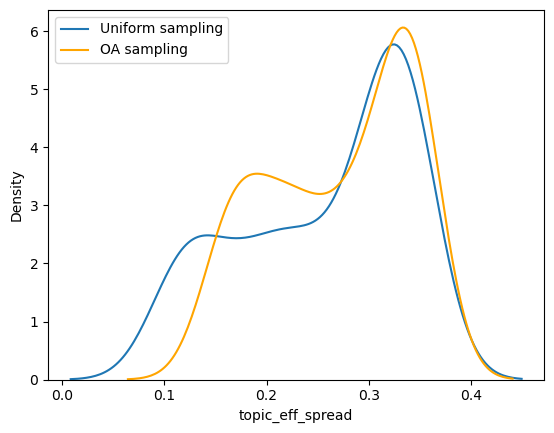

In [189]:
sns.kdeplot(za["topic_eff_spread"], label="Uniform sampling")
sns.kdeplot(za["topic_eff_spreadOA"], color="orange", label="OA sampling")
plt.legend()
plt.show()

In [190]:
# Joining posterior summary stats with scores

s = (testOA.groupby(["sim_cordel_id", "sim_topic_id"]).agg({"intrusion":"sum"})
     .rename(columns={"intrusion":"sumOA"}).reset_index())
c = (testOA.groupby(["sim_cordel_id", "sim_topic_id"]).agg({"intrusion":"count"})
     .rename(columns={"intrusion":"countOA"}).reset_index())
topicsOA = pd.merge(s, c, on=["sim_cordel_id", "sim_topic_id"])
topicsOA["pOA"] = topicsOA["sumOA"]/topicsOA["countOA"]

In [191]:
s = (test.groupby(["sim_cordel_id", "sim_topic_id"]).agg({"intrusion":"sum"})
     .rename(columns={"intrusion":"sum"}).reset_index())
c = (test.groupby(["sim_cordel_id", "sim_topic_id"]).agg({"intrusion":"count"})
     .rename(columns={"intrusion":"count"}).reset_index())
topics = pd.merge(s, c, on=["sim_cordel_id", "sim_topic_id"])
topics["p"] = topics["sum"]/topics["count"]

In [192]:
za = za.drop(columns=[c for c in a.columns if c[:3] in ("par", "hdi")])
a = pd.merge(za, topicsOA, on=["sim_cordel_id", "sim_topic_id"], how="left")
a = pd.merge(a, topics, on=["sim_cordel_id", "sim_topic_id"], how="left")

In [193]:
a["spread_improv"] = a["topic_eff_spreadOA"] - a["topic_eff_spread"]

In [194]:
# The issue is that log odds variance is greatest closest to 0 and 1!!
# To perform the comparison, we need to compare the probability, not log odds.
print("topic_eff_spread measures the difference between 3%hdi and 97%hdi of expit(topic effect)")
var = "spread_improv"
a.sort_values(var)[:10]

topic_eff_spread measures the difference between 3%hdi and 97%hdi of expit(topic effect)


,mean,sd,meanOA,sdOA,hdi_3%OA,hdi_97%OA,sim_cordel_id,sim_topic_id,topic_eff_spread,topic_eff_spreadOA,sumOA,countOA,pOA,sum,count,p,spread_improv
30,0.9463,0.3405,1.1549,0.3814,0.4599,1.8792,0,30,0.295915,0.277367,23,29,0.793103,21,27,0.777778,-0.018548
84,0.8065,0.3184,0.9300,0.3369,0.3291,1.5806,1,34,0.307302,0.289022,23,31,0.741935,20,27,0.740741,-0.018280
82,0.9502,0.3293,1.1557,0.3754,0.4511,1.8563,1,32,0.287222,0.278162,23,29,0.793103,21,27,0.777778,-0.009060
26,0.8081,0.3196,0.9350,0.3409,0.3130,1.5777,0,26,0.301562,0.294069,23,31,0.741935,20,27,0.740741,-0.007493
50,1.2803,0.3790,1.4238,0.4244,0.6344,2.2318,1,0,0.255290,0.248824,22,26,0.846154,23,27,0.851852,-0.006465
49,0.5585,0.2965,0.6397,0.3065,0.0669,1.2159,0,49,0.330557,0.324307,22,33,0.666667,18,27,0.666667,-0.006250
75,0.6831,0.2989,0.7212,0.3148,0.1484,1.3190,1,25,0.318801,0.313537,22,32,0.687500,19,27,0.703704,-0.005264
71,0.8044,0.3073,1.0022,0.3487,0.3659,1.6666,1,21,0.291980,0.286887,22,29,0.758621,20,27,0.740741,-0.005093
1,0.8084,0.3101,0.9998,0.3497,0.3451,1.6406,0,1,0.294335,0.290839,22,29,0.758621,20,27,0.740741,-0.003496
22,0.9480,0.3320,1.0376,0.3571,0.3906,1.7042,0,22,0.285894,0.282869,23,30,0.766667,21,27,0.777778,-0.003025


In [195]:
a.sort_values(var)[-10:]

,mean,sd,meanOA,sdOA,hdi_3%OA,hdi_97%OA,sim_cordel_id,sim_topic_id,topic_eff_spread,topic_eff_spreadOA,sumOA,countOA,pOA,sum,count,p,spread_improv
18,2.5204,0.6093,2.3565,0.6614,1.1460,3.5829,0,18,0.116241,0.158972,15,15,1.000000,27,27,1.000000,0.042731
4,2.0710,0.5249,2.0332,0.5741,0.9419,3.0801,0,4,0.152281,0.196260,18,19,0.947368,26,27,0.962963,0.043978
69,2.5183,0.5982,2.3585,0.6520,1.1502,3.5608,1,19,0.113282,0.157957,15,15,1.000000,27,27,1.000000,0.044675
78,2.5324,0.6238,2.3592,0.6771,1.1264,3.6462,1,28,0.118191,0.163363,15,15,1.000000,27,27,1.000000,0.045172
43,2.5260,0.6253,2.3647,0.6791,1.1349,3.6542,0,43,0.115601,0.161746,15,15,1.000000,27,27,1.000000,0.046145
73,2.5245,0.6359,2.3661,0.6892,1.0748,3.6331,1,23,0.124887,0.173752,15,15,1.000000,27,27,1.000000,0.048866
96,2.5251,0.6172,2.3552,0.6585,1.1522,3.5575,1,46,0.105960,0.157539,15,15,1.000000,27,27,1.000000,0.051579
85,2.5260,0.6131,2.3583,0.6688,1.1137,3.5930,1,35,0.113398,0.165454,15,15,1.000000,27,27,1.000000,0.052056
48,2.5274,0.6265,2.3684,0.6921,1.1034,3.6704,0,48,0.115382,0.168172,15,15,1.000000,27,27,1.000000,0.052790
38,2.5243,0.6297,2.3574,0.6865,1.0806,3.6306,0,38,0.112373,0.172527,15,15,1.000000,27,27,1.000000,0.060154


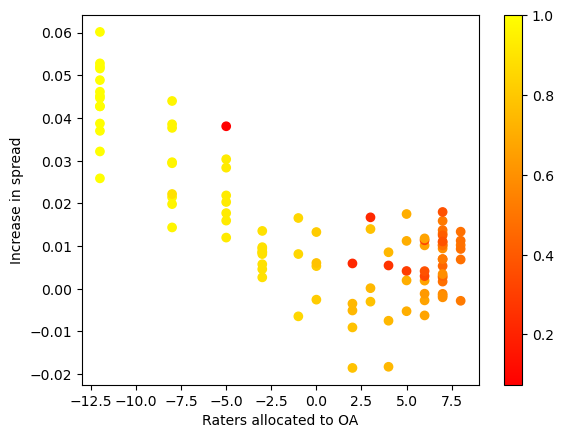

In [196]:
plt.scatter(a["countOA"]-a["count"], a["spread_improv"], c=a["p"], cmap="autumn")
plt.xlabel("Raters allocated to OA")
plt.ylabel("Increase in spread")
plt.colorbar()
plt.show()

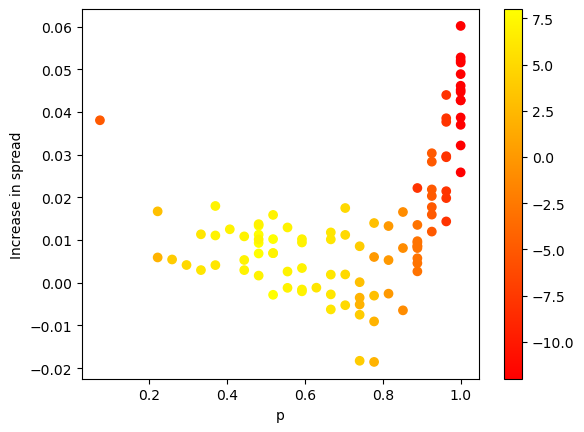

In [197]:
plt.scatter(a["p"], a["spread_improv"], c=a["countOA"]-a["count"], cmap="autumn")
plt.xlabel("p")
plt.ylabel("Increase in spread")
plt.colorbar()
plt.show()

1.4189844661427453


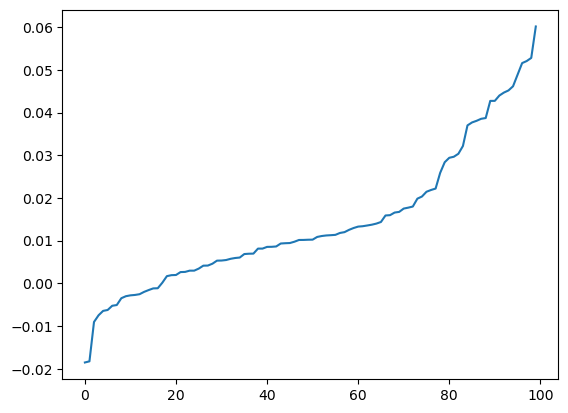

In [198]:
print(a["spread_improv"].sum())
plt.plot(np.array(a.sort_values("spread_improv")["spread_improv"]))
plt.show()

## Testing variance as n_raters increase

In [94]:
s = (testOA.groupby(["sim_cordel_id", "sim_topic_id"]).agg({"intrusion":"sum"})
     .rename(columns={"intrusion":"sum"}).reset_index())
c = (testOA.groupby(["sim_cordel_id", "sim_topic_id"]).agg({"intrusion":"count"})
     .rename(columns={"intrusion":"count"}).reset_index())
topics = pd.merge(s, c, on=["sim_cordel_id", "sim_topic_id"])
topics["p"] = topics["sum"]/topics["count"]

In [95]:
topics.sort_values("count")

,sim_cordel_id,sim_topic_id,sum,count,p
99,1,49,14,14,1.000000
32,0,32,14,14,1.000000
36,0,36,14,14,1.000000
41,0,41,14,14,1.000000
52,1,2,14,14,1.000000
...,...,...,...,...,...
61,1,11,32,62,0.516129
95,1,45,29,62,0.467742
1,0,1,34,62,0.548387
28,0,28,30,62,0.483871


In [123]:
topics[(topics["sim_cordel_id"]==1) & (topics["sim_topic_id"]==2)]

,sim_cordel_id,sim_topic_id,sum,count,p
52,1,2,14,14,1.0


In [28]:
summary_statsOA = pd.DataFrame()
df = testOA
seed = 42+sim_id

for n_rater in range(55, 136, 10):
# n_raters = 100
    print(n_rater)
    sample = df[df["sim_rater_id"]<n_rater]   
    
    if seed != None:
        np.random.seed(seed)

    # Bayesian hypothesis tests whether the two distributions in the sample are statisticaly significant
    # Setting up numpy arrays for pymc
    # Only 2 models and 1 corpus in simulation
    corpus_array = np.array([0]*len(sample))
    n_corpora = 1

    model_array = np.array(sample["sim_cordel_id"])
    n_models = sample["sim_cordel_id"].nunique()

    cordel_array = np.array(sample["sim_cordel_id"])
    n_cordels = sample["sim_cordel_id"].nunique()

    topic_array = np.array([sample["sim_cordel_id"], sample["sim_topic_id"]])
    n_topics = sample["sim_topic_id"].nunique()

    rater_array = np.array(sample["sim_rater_id"])
    n_raters = sample["sim_rater_id"].nunique()

    score_array = np.array(sample["intrusion"])

    # Model and MCMC specifications
    empirical_mean = logit(0.75)
    r_lambda = 2
    t_lambda = 1
    t_sigma = 1
    # cm_lambda = 2
    # cm_sigma = 1
    mu_sigma = 1

    # Rater, Topic, Cordel model

    model = pm.Model()
    with model:
        # Hyperparameter priors
        raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
        topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
        cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")

        sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
        zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
        sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
        za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
        mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma, shape=n_cordels)

        s = pm.Bernoulli(
                "s", 
                p=pm.math.invlogit(
                    mu[cordels]+
                    za[topics[0],topics[1]]*sigma_a+
                    zr[raters]*sigma_r),
                observed=score_array, 
                dims="obs_id")

        c_mean0 = pm.Deterministic("c_mean0", mu[0] + za[0].mean()*sigma_a)
        c_mean1 = pm.Deterministic("c_mean1", mu[1] + za[1].mean()*sigma_a)
        c_diff = pm.Deterministic("c_diff", c_mean1 - c_mean0)
    #     c_mean = pm.Deterministic("c_mean", 
    #                               pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
    #                               dims="obs_id")
    #     c_diff = pm.Deterministic("c_diff", c_mean.reshape([n_cordels,1]) - c_mean.reshape([1,n_cordels]), dims="obs_id")

        if SAMPLE_JAX:
            trace=sample_numpyro_nuts(chains=n_chains, random_seed=np.random.randint(2**20), chain_method=chain_method)
        else:
            trace=pm.sample(chains=n_chains, random_seed=np.random.randint(2**20))

    n_neg = (trace.posterior["c_diff"]<0).sum().item()
    total = trace.posterior["c_diff"].count().item()
    pval = n_neg/total
    print(pval)

    summary_stat = create_summary_stat(trace)
    summary_stat.insert(0, column="n_raters", value=n_raters)
    summary_stat["pval"]=pval
    summary_statsOA = pd.concat([summary_statsOA, summary_stat], ignore_index=True)

55
Compiling...
Compilation time =  0:00:01.051810
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:25<00:00, 78.73it/s]


Sampling time =  0:00:25.687945
Transforming variables...
Transformation time =  0:00:00.065750
Computing Log Likelihood...
Log Likelihood time =  0:00:00.610427
0.0395
65
Compiling...
Compilation time =  0:00:01.012884
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:28<00:00, 70.88it/s]


Sampling time =  0:00:28.471327
Transforming variables...
Transformation time =  0:00:00.074820
Computing Log Likelihood...
Log Likelihood time =  0:00:00.636429
0.0545
75
Compiling...
Compilation time =  0:00:01.019577
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:30<00:00, 66.62it/s]


Sampling time =  0:00:30.332828
Transforming variables...
Transformation time =  0:00:00.098785
Computing Log Likelihood...
Log Likelihood time =  0:00:01.013931
0.0235
85
Compiling...
Compilation time =  0:00:01.297205
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:32<00:00, 60.87it/s]


Sampling time =  0:00:33.144694
Transforming variables...
Transformation time =  0:00:00.068514
Computing Log Likelihood...
Log Likelihood time =  0:00:00.877435
0.164
95
Compiling...
Compilation time =  0:00:01.043059
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:36<00:00, 54.31it/s]


Sampling time =  0:00:37.089005
Transforming variables...
Transformation time =  0:00:00.065963
Computing Log Likelihood...
Log Likelihood time =  0:00:01.117408
0.059
105
Compiling...
Compilation time =  0:00:01.086803
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:41<00:00, 47.81it/s]


Sampling time =  0:00:42.126125
Transforming variables...
Transformation time =  0:00:00.070530
Computing Log Likelihood...
Log Likelihood time =  0:00:01.281986
0.0355
115
Compiling...
Compilation time =  0:00:01.481448
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:40<00:00, 49.24it/s]


Sampling time =  0:00:40.911647
Transforming variables...
Transformation time =  0:00:00.071269
Computing Log Likelihood...
Log Likelihood time =  0:00:01.176159
0.075
125
Compiling...
Compilation time =  0:00:01.092332
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:47<00:00, 42.51it/s]


Sampling time =  0:00:47.374151
Transforming variables...
Transformation time =  0:00:00.091366
Computing Log Likelihood...
Log Likelihood time =  0:00:01.223234
0.076
135
Compiling...
Compilation time =  0:00:01.136767
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:45<00:00, 43.70it/s]


Sampling time =  0:00:46.088789
Transforming variables...
Transformation time =  0:00:00.066072
Computing Log Likelihood...
Log Likelihood time =  0:00:01.523388
0.041


In [71]:
summary_stats = pd.DataFrame()
df = test
seed = 42+sim_id

for n_rater in range(55, 136, 10):
# n_raters = 100
    print(n_rater)
    sample = df[df["sim_rater_id"]<n_rater]   
    
    if seed != None:
        np.random.seed(seed)

    # Bayesian hypothesis tests whether the two distributions in the sample are statisticaly significant
    # Setting up numpy arrays for pymc
    # Only 2 models and 1 corpus in simulation
    corpus_array = np.array([0]*len(sample))
    n_corpora = 1

    model_array = np.array(sample["sim_cordel_id"])
    n_models = sample["sim_cordel_id"].nunique()

    cordel_array = np.array(sample["sim_cordel_id"])
    n_cordels = sample["sim_cordel_id"].nunique()

    topic_array = np.array([sample["sim_cordel_id"], sample["sim_topic_id"]])
    n_topics = sample["sim_topic_id"].nunique()

    rater_array = np.array(sample["sim_rater_id"])
    n_raters = sample["sim_rater_id"].nunique()

    score_array = np.array(sample["intrusion"])

    # Model and MCMC specifications
    empirical_mean = logit(0.75)
    r_lambda = 2
    t_lambda = 1
    t_sigma = 1
    # cm_lambda = 2
    # cm_sigma = 1
    mu_sigma = 1

    # Rater, Topic, Cordel model

    model = pm.Model()
    with model:
        # Hyperparameter priors
        raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
        topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
        cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")

        sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
        zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
        sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
        za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
        mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma, shape=n_cordels)

        s = pm.Bernoulli(
                "s", 
                p=pm.math.invlogit(
                    mu[cordels]+
                    za[topics[0],topics[1]]*sigma_a+
                    zr[raters]*sigma_r),
                observed=score_array, 
                dims="obs_id")

        c_mean0 = pm.Deterministic("c_mean0", mu[0] + za[0].mean()*sigma_a)
        c_mean1 = pm.Deterministic("c_mean1", mu[1] + za[1].mean()*sigma_a)
        c_diff = pm.Deterministic("c_diff", c_mean1 - c_mean0)
    #     c_mean = pm.Deterministic("c_mean", 
    #                               pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
    #                               dims="obs_id")
    #     c_diff = pm.Deterministic("c_diff", c_mean.reshape([n_cordels,1]) - c_mean.reshape([1,n_cordels]), dims="obs_id")

        if SAMPLE_JAX:
            trace=sample_numpyro_nuts(chains=n_chains, random_seed=np.random.randint(2**20), chain_method=chain_method)
        else:
            trace=pm.sample(chains=n_chains, random_seed=np.random.randint(2**20))

    n_neg = (trace.posterior["c_diff"]<0).sum().item()
    total = trace.posterior["c_diff"].count().item()
    pval = n_neg/total
    print(pval)

    summary_stat = create_summary_stat(trace)
    summary_stat.insert(0, column="n_raters", value=n_raters)
    summary_stat["pval"]=pval
    summary_stats = pd.concat([summary_stats, summary_stat], ignore_index=True)

55
Compiling...
Compilation time =  0:00:03.200976
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:22<00:00, 88.14it/s]


Sampling time =  0:00:22.948162
Transforming variables...
Transformation time =  0:00:00.064738
Computing Log Likelihood...
Log Likelihood time =  0:00:00.744071
0.1575
65
Compiling...
Compilation time =  0:00:01.271385
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:27<00:00, 73.60it/s]


Sampling time =  0:00:27.439506
Transforming variables...
Transformation time =  0:00:00.068029
Computing Log Likelihood...
Log Likelihood time =  0:00:00.598635
0.1145
75
Compiling...
Compilation time =  0:00:01.001231
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:29<00:00, 67.27it/s]


Sampling time =  0:00:29.983087
Transforming variables...
Transformation time =  0:00:00.066410
Computing Log Likelihood...
Log Likelihood time =  0:00:00.866909
0.107
85
Compiling...
Compilation time =  0:00:01.058533
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:29<00:00, 67.85it/s]


Sampling time =  0:00:29.744977
Transforming variables...
Transformation time =  0:00:00.067974
Computing Log Likelihood...
Log Likelihood time =  0:00:01.101019
0.172
95
Compiling...
Compilation time =  0:00:01.070508
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:32<00:00, 61.73it/s]


Sampling time =  0:00:32.665834
Transforming variables...
Transformation time =  0:00:00.066256
Computing Log Likelihood...
Log Likelihood time =  0:00:01.168985
0.0865
105
Compiling...
Compilation time =  0:00:01.210352
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:39<00:00, 50.63it/s]


Sampling time =  0:00:39.814352
Transforming variables...
Transformation time =  0:00:00.070539
Computing Log Likelihood...
Log Likelihood time =  0:00:01.040721
0.0715
115
Compiling...
Compilation time =  0:00:00.989649
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:40<00:00, 49.52it/s]


Sampling time =  0:00:40.645962
Transforming variables...
Transformation time =  0:00:00.070425
Computing Log Likelihood...
Log Likelihood time =  0:00:01.718161
0.055
125
Compiling...
Compilation time =  0:00:01.860461
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:48<00:00, 41.55it/s]


Sampling time =  0:00:48.534869
Transforming variables...
Transformation time =  0:00:00.066270
Computing Log Likelihood...
Log Likelihood time =  0:00:01.759097
0.009
135
Compiling...
Compilation time =  0:00:01.052314
Sampling...


sample: 100%|███████████████████████████████| 2000/2000 [00:58<00:00, 34.03it/s]


Sampling time =  0:00:59.095704
Transforming variables...
Transformation time =  0:00:00.096158
Computing Log Likelihood...
Log Likelihood time =  0:00:01.445033
0.0075


In [118]:
s=summary_statsOA
s[(s["n_raters"]==135)&(s["param"]=="za")].sort_values("sd")

,n_raters,param,param_num,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,pval
1772,135,za,"1, 11",-0.9401,0.2716,-1.4579,-0.4442,0.0116,0.0082,547.9031,1067.6673,0.9994,0.041
1806,135,za,"1, 45",-1.0796,0.2731,-1.5770,-0.5875,0.0117,0.0083,551.4162,1277.6295,1.0007,0.041
1739,135,za,"0, 28",-0.8837,0.2733,-1.3985,-0.3783,0.0121,0.0085,514.5587,981.3612,1.0044,0.041
1738,135,za,"0, 27",-0.6004,0.2736,-1.1392,-0.1057,0.0114,0.0081,569.7770,1264.5453,1.0001,0.041
1728,135,za,"0, 17",-0.7451,0.2739,-1.2502,-0.2331,0.0118,0.0084,537.5874,906.2229,1.0009,0.041
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1752,135,za,"0, 41",1.4284,0.6711,0.2405,2.7330,0.0141,0.0111,2349.4775,1436.7692,0.9999,0.041
1720,135,za,"0, 9",1.3693,0.6711,0.2289,2.7405,0.0167,0.0136,1802.4481,1068.5419,1.0022,0.041
1741,135,za,"0, 30",1.3989,0.6772,0.1387,2.6693,0.0161,0.0124,1802.7732,1258.4709,1.0002,0.041
1810,135,za,"1, 49",1.3494,0.7039,0.0660,2.6969,0.0139,0.0118,2672.5266,1321.4180,1.0034,0.041


In [122]:
s=summary_stats
s[(s["n_raters"]==135)&(s["param"]=="za")].sort_values("sd")

,n_raters,param,param_num,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,pval
3589,135,za,"1, 10",-0.5587,0.2685,-1.0371,-0.0363,0.0126,0.0089,453.0951,1330.4486,1.0000,0.0075
3586,135,za,"1, 7",-0.7095,0.2714,-1.2000,-0.1800,0.0110,0.0078,609.0751,1102.4356,1.0011,0.0075
3562,135,za,"0, 33",-0.4941,0.2723,-0.9712,0.0422,0.0101,0.0072,720.0414,1208.2372,1.0007,0.0075
3556,135,za,"0, 27",-0.3957,0.2733,-0.9216,0.0887,0.0103,0.0073,707.5823,922.7898,1.0003,0.0075
3577,135,za,"0, 48",-0.8147,0.2733,-1.3088,-0.3071,0.0098,0.0070,767.4423,1131.7557,1.0011,0.0075
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3621,135,za,"1, 42",1.6361,0.5156,0.6483,2.5654,0.0129,0.0099,1690.9087,1204.5883,0.9993,0.0075
3615,135,za,"1, 36",1.6491,0.5341,0.7746,2.7345,0.0142,0.0106,1497.8296,1206.1413,0.9995,0.0075
3538,135,za,"0, 9",2.0388,0.5808,1.0082,3.1436,0.0136,0.0103,1905.1905,1215.0212,0.9999,0.0075
3570,135,za,"0, 41",2.0593,0.5853,0.9108,3.1027,0.0128,0.0094,2122.7369,1430.9887,1.0021,0.0075


/tmp/ipykernel_56891/1724900651.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0.loc[:,"topic_effect_sd"]=s0["sd"]*s0["sigma_a"]


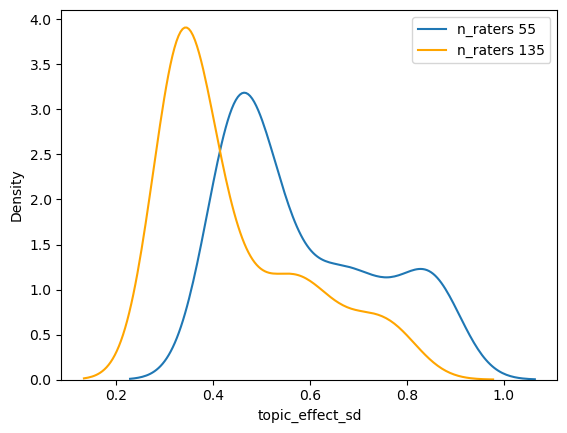

In [115]:
s=summary_statsOA
sigma_a = s[s["param"]=="sigma_a"]
sigma_a=sigma_a.rename(columns={"mean":"sigma_a"})[["n_raters", "sigma_a"]]
s = pd.merge(s, sigma_a, on="n_raters", how="left")
s0=s[(s["param"]=="za")]
s0.loc[:,"topic_effect_sd"]=s0["sd"]*s0["sigma_a"]

sns.kdeplot(s0[s0["n_raters"]==55]["topic_effect_sd"], label="n_raters 55")
sns.kdeplot(s0[s0["n_raters"]==135]["topic_effect_sd"], c="orange", label="n_raters 135")
plt.legend()
plt.show()

/tmp/ipykernel_56891/1454429574.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s0.loc[:,"topic_effect_sd"]=s0["sd"]*s0["sigma_a"]


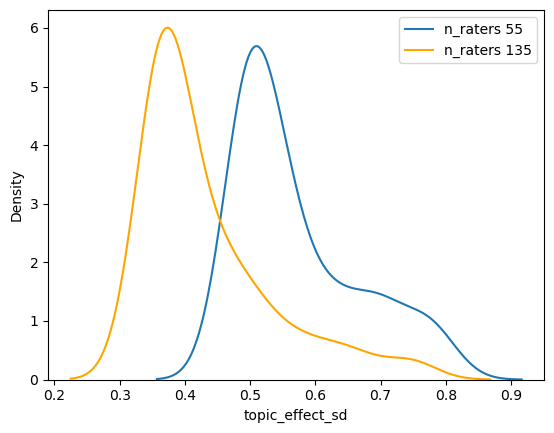

In [116]:
s=summary_stats
sigma_a = s[s["param"]=="sigma_a"]
sigma_a=sigma_a.rename(columns={"mean":"sigma_a"})[["n_raters", "sigma_a"]]
s = pd.merge(s, sigma_a, on="n_raters", how="left")
s0=s[(s["param"]=="za")]
s0.loc[:,"topic_effect_sd"]=s0["sd"]*s0["sigma_a"]

sns.kdeplot(s0[s0["n_raters"]==55]["topic_effect_sd"], label="n_raters 55")
sns.kdeplot(s0[s0["n_raters"]==135]["topic_effect_sd"], c="orange", label="n_raters 135")
plt.legend()
plt.show()

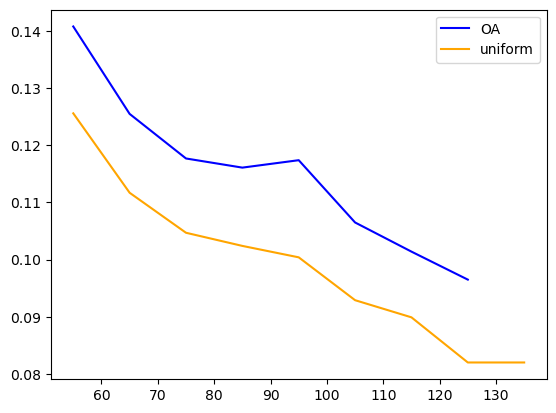

In [108]:
s = summary_statsOA
# param = "mu"
# param_num = "0"
param = "c_diff"
param_num = None
stat = "sd"

if param_num==None:
    s0 = s[(s["param"]==param)]
else:
    s0 = s[(s["param"]==param)&(s["param_num"]==param_num)]

plt.plot(s0["n_raters"], s0[stat], c="blue", label="OA")


s = summary_stats

if param_num==None:
    s0 = s[(s["param"]==param)]
else:
    s0 = s[(s["param"]==param)&(s["param_num"]==param_num)]

plt.plot(s0["n_raters"], s0[stat], c="orange", label="uniform")
plt.legend()
plt.show()